In [426]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt
import math

In [427]:
device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(device)

cuda


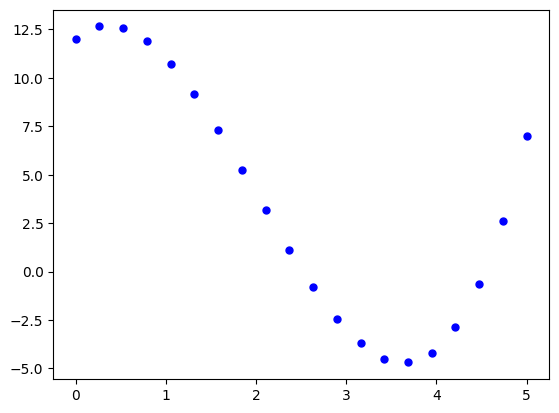

X [0.         0.26315789 0.52631579 0.78947368 1.05263158 1.31578947
 1.57894737 1.84210526 2.10526316 2.36842105 2.63157895 2.89473684
 3.15789474 3.42105263 3.68421053 3.94736842 4.21052632 4.47368421
 4.73684211 5.        ]
Y [12.         12.65534334 12.58900714 11.91033678 10.72867765  9.15337513
  7.2937746   5.25922146  3.15906109  1.10263887 -0.80069981 -2.44160956
 -3.71074501 -4.49876075 -4.69631142 -4.19405161 -2.88263595 -0.65271906
  2.60504447  7.        ]
-------


In [448]:
x = np.linspace(0, 5, 20)
y = x**3 -6*x**2 + 4*x + 12
plt.plot(x, y,'bo', markersize = 5)
plt.show()
print("X", x)
print("Y", y)
print("-------")

In [449]:
x_t = t.from_numpy(x).to(device)
y_t = t.from_numpy(y).to(device)
print(x_t)
print(y_t)

tensor([0.0000, 0.2632, 0.5263, 0.7895, 1.0526, 1.3158, 1.5789, 1.8421, 2.1053,
        2.3684, 2.6316, 2.8947, 3.1579, 3.4211, 3.6842, 3.9474, 4.2105, 4.4737,
        4.7368, 5.0000], device='cuda:0', dtype=torch.float64)
tensor([12.0000, 12.6553, 12.5890, 11.9103, 10.7287,  9.1534,  7.2938,  5.2592,
         3.1591,  1.1026, -0.8007, -2.4416, -3.7107, -4.4988, -4.6963, -4.1941,
        -2.8826, -0.6527,  2.6050,  7.0000], device='cuda:0',
       dtype=torch.float64)


In [450]:
class Population:
    def __init__(self, population_len, genome_len, x, y, is_highest_best=True, genomes=None, epsilon=0.03):
        self.population_len = population_len
        self.genome_len = genome_len
        self.generation = -1
        self.is_highest_best = is_highest_best
        self.epsilon = epsilon
        self.genomes = genomes if genomes is not None else t.randn(population_len, genome_len, device=device)
        self.fitness = None
        self.probability = None
        self.tau = 1/math.sqrt(genome_len)
        # 
        self.x = x.expand(self.population_len, x.size(0))
        self.y = y.expand(self.population_len, y.size(0))
        
        self.updatePopulation()
    
    def __str__(self):
        strs = list()
        strs.append(f'Generation: {self.generation}')
        # strs.append(f'Genomes: {self.genomes}')
        return '\n'.join(strs)
    
    def updatePopulation(self):
        self.generation += 1
        self.set_fitness()
        self.set_probability()
    
    def get_phenotype(self):
        return t.pow(self.x, 3)*self.genomes[:,0].unsqueeze(1) + t.square(self.x)*self.genomes[:,1].unsqueeze(1) + self.x*self.genomes[:,2].unsqueeze(1) + self.genomes[:,3].unsqueeze(1)
        
    
    def set_fitness(self):
        # print("X:", self.x)
        res = self.get_phenotype()
        # print("RES:", res)
        # print("Y:", self.y)
        res.sub_(self.y).abs_()
        # print("RES:", res)
        self.fitness = t.mean(res, dim=1)
        # print("Fit:", self.fitness)
        
    def set_probability(self):
        if self.is_highest_best:
            self.probability = self.fitness / t.sum(self.fitness)
        else:
            self.probability = 1 / self.fitness
            self.probability.div_(t.sum(self.probability))
        # print("Prob:", self.probability)
        
    def get_best_id(self):
        return t.argmax(self.probability)
    
    def get_best_fitness(self):
        return self.fitness[self.get_best_id()]
    
    def get_best_genome(self):
        return self.genomes[self.get_best_id(), :]
    
    def evolve(self):
        self.crossover()
        self.mutation()
        self.updatePopulation()
        # print(self)
        # print("Best fitness:", self.fitness[self.get_best_id()])
        
    def evolve_for_generations(self, generations):
        for _ in range(generations):
            self.evolve()
        print(self)
        print("Best fitness:", self.get_best_fitness())
        
    def get_parents(self):
        parents = self.probability.expand(self.population_len, self.population_len).multinomial(2)
        # print("Parents:", parents)
        p1 = self.genomes[parents[:,0],:]
        p2 = self.genomes[parents[:,1],:]
        # print("P1:", p1)
        return p1, p2
    
    def crossover(self):
        p1, p2 = self.get_parents()
        u = t.rand(self.population_len, self.genome_len, device=device) * 2
        self.genomes = p1 * (1.5 - u) + p2 * (u - 0.5)
    
    def mutation(self):
        sigma = t.exp(t.randn(self.population_len, device=device) * self.tau) * self.genomes[:,-1]
        sigma.clamp_(min=self.epsilon)
        self.genomes += t.randn(self.population_len, self.genome_len, device=device) * sigma.unsqueeze(1)
        self.genomes[:,-1] = sigma

In [451]:
def show_graph(population):
    res_y = population.get_phenotype()[population.get_best_id(),:].cpu().numpy()
    plt.plot(x, y, color='b', linestyle='--')
    plt.plot(x, y,'bo', markersize = 5)
    plt.plot(x, res_y, color='r', linestyle='--')
    plt.plot(x, res_y,'ro', markersize = 5)
    plt.show()

In [452]:
def test_for(count):
    population_len = 400
    genome_len = 5
    generations = 5000
    sum = 0
    for _ in range(count):
        population = Population(population_len, genome_len, x_t, y_t, is_highest_best=False, genomes=genomes)
        population.evolve_for_generations(generations)
        sum += population.get_best_fitness()
    print("Average best fitness:", sum/count)

In [453]:
population_len = 400
genome_len = 5
genomes = t.randn(population_len, genome_len, device=device)

Generation: 0


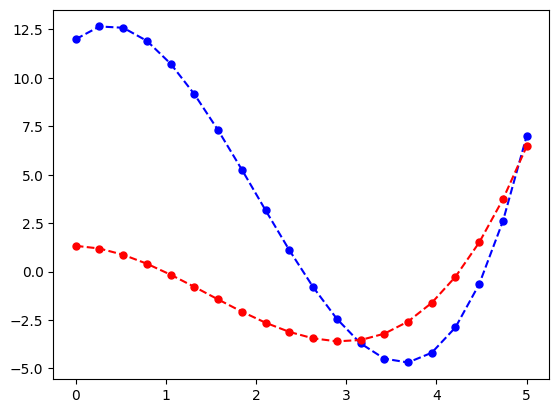

In [454]:
population = Population(population_len, genome_len, x_t, y_t, is_highest_best=False, genomes=genomes)
print(population)
show_graph(population)

Generation: 10055
Best fitness: tensor(0.0415, device='cuda:0', dtype=torch.float64)


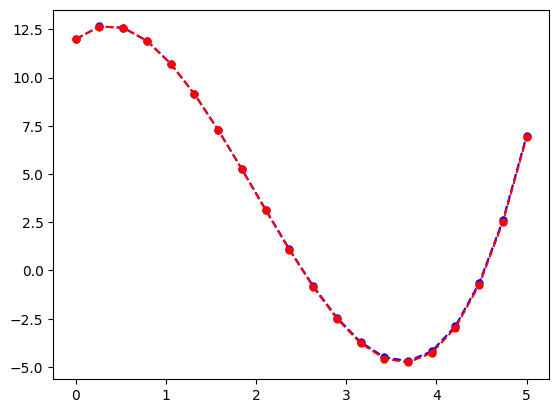

tensor([ 1.0028, -6.0227,  4.0280, 11.9922,  0.0300], device='cuda:0')


In [458]:
population.evolve_for_generations(5000)
show_graph(population)
print(population.get_best_genome())